## Dow Jones Index Price Direction Prediction
- Data has been provided by UCI as specified here: https://archive.ics.uci.edu/ml/datasets/Dow+Jones+Index
- Further Reference on this data souce can be found in this paper: 
  "Brown, M. S., Pelosi, M. & Dirska, H. (2013). Dynamic-radius Species-conserving Genetic Algorithm for 
  the Financial Forecasting of Dow Jones Index Stocks. Machine Learning and Data Mining in Pattern 
  Recognition, 7988, 27-41."
- I have also referred to some best practises on feature enginerring, data cleaning/visualisation and ML helpers functions etc from a Kaggle notebook titled: "Introduction to Ensembling/Stacking in Python" Developed by Anistropic. Further details of this can be sourced here: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python



### Add the imports

In [1]:
#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Specify the global variables and constants

In [3]:
data_path = '..\Dow_Jones_Index_Price_Prediction_Problem\Data\dow_jones_index.data'

### Sourcing the data
 - Read data from CSV store
 - Some feature engineering, in this case specify the response/output as the direction of the furture returns
 - Some data clean; remove unwanted features in the data
 - It conversts the Currency attributes into floats

In [227]:
def renameColumns(data):
    '''
    Used to rename feature columns of the data container 
    '''
    col_mapper = {'percent_change_price':'return_t0',
                  'percent_change_volume_over_last_wk':'vol_chg_t0',
                  'previous_weeks_volume':'vol_tminus_1',
                  'days_to_next_dividend':'next_div_days',
                  'percent_return_next_dividend':'next_div_return'
                 }
    return data.rename(columns=col_mapper)
    
def currency2Float(x):
    '''
    Converts currency into string type
    '''
    result = x.replace('$','').replace(',','')
    return result
def convertCurrencyColsToFloats(data, cols):
    '''
    Converts Currency feature columns into floats
    '''    
    try:
        for col in cols:
            data[col] = data[col].apply(lambda x: currency2Float(x)).astype('float')
    except Exception as e:
        print("Error occured: Missing columns in DataFrame!!".format(e))
    return data
def signExtra(x):
    y = np.sign(x)
    if y == -1:
        return 0
    else:
        return y
vecSign = np.vectorize(signExtra)
    
def getData():
    """
    Gets the Dow Jones Index data. 
    It removes unwanted feature columns
    Also it computes the output/response of the model as the direction of the future returns    
    """
    raw_data = pd.read_csv(data_path)
    # raw_data["price_pct_change"] = (raw_data.close.apply(lambda x: x.replace('$',''))
    #                 .apply(lambda x: x.replace(',','')).astype('float').pct_change())
    drop_cols = ['quarter','stock','date','next_weeks_open',
                 'next_weeks_close','percent_change_next_weeks_price',
                 'volume','previous_weeks_volume',
                 'open', 'high', 'low', 'close']    
    raw_data['direction'] = vecSign(raw_data.percent_change_next_weeks_price)
    raw_data.drop(drop_cols, axis=1, inplace=True)
    raw_data = renameColumns(raw_data) 
    return raw_data.dropna()
data1 = getData()
cols = ['open', 'high', 'low', 'close']
data2 = convertCurrencyColsToFloats(data1, cols)
data2.head(10)
#data2.dtypes

Error occured: Missing columns in DataFrame!!


,return_t0,vol_chg_t0,next_div_days,next_div_return,direction
1,-4.428490,1.380223,19,0.187852,0
2,-2.470660,-43.024959,12,0.189994,1
3,1.638310,9.355500,5,0.185989,1
4,5.933250,1.987452,97,0.175029,1
5,0.230814,-25.712195,90,0.172712,0
6,-0.632547,-30.226696,83,0.173611,0
7,-1.766780,66.177694,76,0.179856,0
8,-1.368230,-17.663150,69,0.180941,0
9,-3.317250,4.419900,62,0.187149,1
10,1.003130,14.030601,55,0.186220,1


### Some Feature Engineering
This step will modify the features in the following ways:
 - Provide "lookback" (lag) price change i.e. return_t0 using Pandas shift(i) (we will experiment with lag up to 4 week)
 - Provide "lookback" (lag) dividend returns i.e. next_div_return (we will experiment with lag up to 4 week)
 - Optionally further lag the change in volume i.e. vol_chg_t0 by an additional 4 weeks

The rationale is that since the frequency of the feature data is weekly we get the model to capture monthly (4 weeks back) variations

In [232]:
def reOrderColumns(data, col_name='direction'):
    cols = list(data.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index(col_name)) #Remove b from list
    data = data[cols+[col_name]] #Create new dataframe with column
    return data

def engineerFeatureData(data, is_lag_price=True, is_lag_div=True, is_lag_vol=False):
    price_lag = 4
    div_lag = price_lag
    vol_lag = price_lag
    vol_lead = 1
    
    data_change = data.copy()
     
    # Engineer the price feature
    data_change["price_t0"] = data["return_t0"].copy()
    if is_lag_price:
        for i in range(0, price_lag):
            data_change["price_t{}".format(str(i+1))] = data_change["price_t0"].shift(i+1)

    # Engineer the dividend feature
    data_change["div_t0"] = data["next_div_return"]
    if is_lag_div:
        for i in range(0, div_lag):
            data_change["div_t{}".format(str(i+1))] = data_change["div_t0"].shift(i+1)

    # Engineer the volume feature
    data_change["vol_t0"] = data["vol_chg_t0"]
    if is_lag_vol:
        for i in range(0, vol_lag):
            data_change["vol_t{}".format(str(i+1))] = data_change["vol_t0"].shift(i+1)

    # Further clean-up drop old columns
    drop_cols = ['return_t0', 'next_div_return', 'vol_chg_t0']
    data_change.drop(drop_cols, axis=1, inplace=True)
    new_data = reOrderColumns(data_change)
    return new_data.dropna()

data3 = engineerFeatureData(data2)
data3.head(10)

,next_div_days,price_t0,price_t1,price_t2,price_t3,price_t4,div_t0,div_t1,div_t2,div_t3,div_t4,vol_t0,direction
5,90,0.230814,5.933250,1.638310,-2.470660,-4.428490,0.172712,0.175029,0.185989,0.189994,0.187852,-25.712195,0
6,83,-0.632547,0.230814,5.933250,1.638310,-2.470660,0.173611,0.172712,0.175029,0.185989,0.189994,-30.226696,0
7,76,-1.766780,-0.632547,0.230814,5.933250,1.638310,0.179856,0.173611,0.172712,0.175029,0.185989,66.177694,0
8,69,-1.368230,-1.766780,-0.632547,0.230814,5.933250,0.180941,0.179856,0.173611,0.172712,0.175029,-17.663150,0
9,62,-3.317250,-1.368230,-1.766780,-0.632547,0.230814,0.187149,0.180941,0.179856,0.173611,0.172712,4.419900,1
10,55,1.003130,-3.317250,-1.368230,-1.766780,-0.632547,0.186220,0.187149,0.180941,0.179856,0.173611,14.030601,1
11,48,4.334550,1.003130,-3.317250,-1.368230,-1.766780,0.175541,0.186220,0.187149,0.180941,0.179856,-26.710607,1
13,82,4.638010,4.334550,1.003130,-3.317250,-1.368230,0.389189,0.175541,0.186220,0.187149,0.180941,-42.544258,0
14,75,-0.065175,4.638010,4.334550,1.003130,-3.317250,0.391304,0.389189,0.175541,0.186220,0.187149,49.823099,0
15,68,-4.755700,-0.065175,4.638010,4.334550,1.003130,0.410397,0.391304,0.389189,0.175541,0.186220,32.460101,0


### Analyse response data (y) Class balance - Is it imbalance?

In [233]:
def reportClassImbalance(data):
    '''
    Reports the response data class imbalance 
    '''
    result = np.array(data['direction'].value_counts())
    print("Class balance is: ")
    for i, v in enumerate(result.tolist()):
        print("   Class {0} is {1}".format(i,v))
        

reportClassImbalance(data3)

Class balance is: 
   Class 0 is 359
   Class 1 is 357


### Analyse Feature correlation
 - Construct a Pearson Correlation Heatmap for the feature space

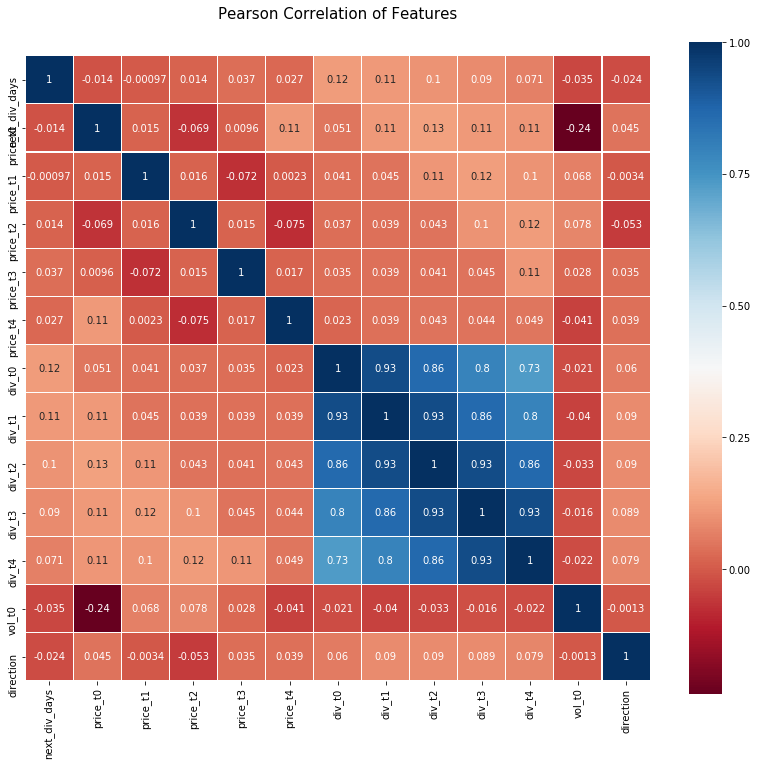

In [234]:
def plotPearsonHeatMap(data):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plotPearsonHeatMap(data3)

### Conclusions from the feature correlation heatmap
 - There is a strong positive correlation (i.e. 1) between the features: open, high, low and close prices. This is expected and seems intuitive. We could safely remove these features but I am going to leave them in the model for the time being
 - There also seems to be a strong positive correlation between the features: volume and previous_week_volume. Again this is expected. Ordinarily I only need 1 of these features. But for the 1st iteration of this exercise I will keep both of these features in the analysis. 

### Plot Distributions of the features
 - We will generate some plots to observe the distribution of data for each feature.
 - Also will generate a feature-feature plot called a scatter-matrix in Pandas

### Generate Feature Distributions

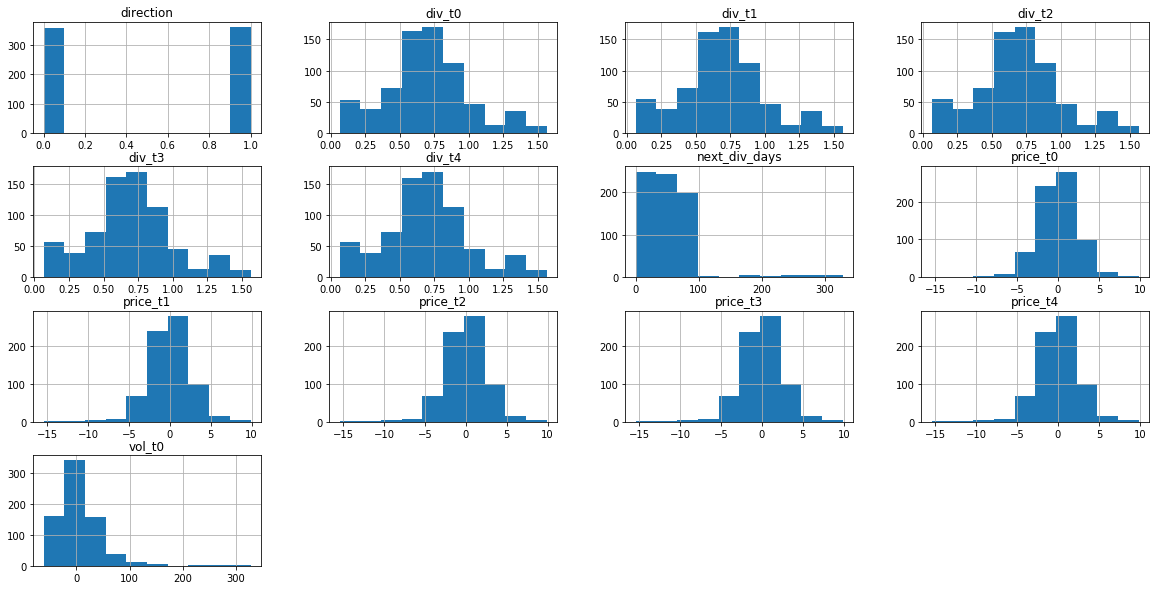

In [235]:
#pd.options.display.mpl_style = 'default'
plt.rcParams["figure.figsize"] = (20,10)
def generateDistributionPlots(data):
    '''
    Plots the histogram of each feature
    '''
    data.hist()
    
generateDistributionPlots(data3)


### Generate Scatter-Matrix (Pair Plots)

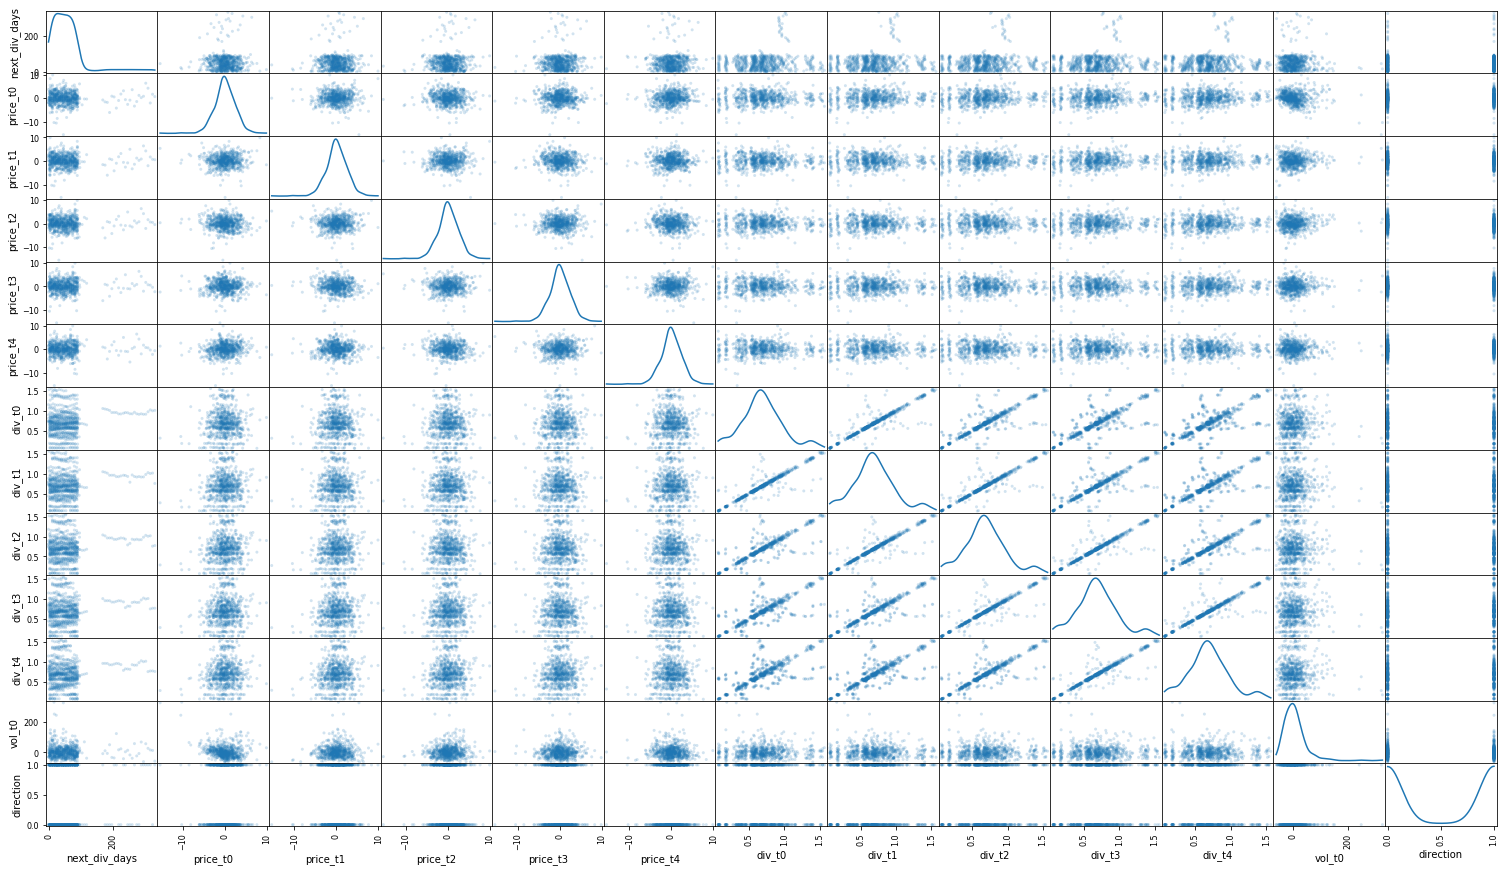

In [236]:
def generateScatterMatixPlot(data):
    '''
    Plots the Scatter-Matrix showing the feature-feature relationships
    '''
    from pandas.plotting import scatter_matrix
    scatter_matrix(data, alpha=0.2, figsize=(26, 15), diagonal='kde')
    
generateScatterMatixPlot(data3)

### Create Some helpers to wrap the ML models for ease of use
 - Wrappers to split the data
 - Wrappers to conviniently call ML models such as Scikit Learn or Deep Learn frameworks

### Define the ML model imports

In [237]:
from sklearn.model_selection import (train_test_split, KFold)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Preprocess the data - scale data to by removing the mean and scaling to unit variance
 - We will the sklearn.preprocessing.StandardScaler

In [238]:
from sklearn.preprocessing import StandardScaler

def scaleXData(X):
    '''
    Compute the mean and std that is used scale the X feature data to zero mean and unit variance
    '''
    scaler = StandardScaler()
    scaler.fit(X)
    X_scale = scaler.transform(X)
    return scaler, X_scale

### Set ML model parameters

In [292]:
def splitData(data, split_fraction=0.3, seed=10):
    '''
    Split the data into Test/Train datasets
    '''
    y = np.array(data[data.columns[-1]])
    X = np.array(data[data.columns[:-1]])
    scaler, X_scale = scaleXData(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=split_fraction, random_state=seed)
    return scaler, X_train, X_test, y_train, y_test

from numpy.random import seed
seed(SEED)
N_FEATURES = X_train.shape[1]
N_TRAIN_SAMPLES = X_train.shape[0]
N_TEST_SAMPLES = X_test.shape[0]
SEED = 10
SPLIT_FRACTION = 0.3
scaler, X_train, X_test, y_train, y_test = splitData(data3,SPLIT_FRACTION,SEED)
NFOLDS = 5 # set folds for out-of-fold prediction
# kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)


### Cross Validation logic to be based on Scikit Learn's K-Folds cross-validator
- Construct the KFold object to define the cross validation routine

In [293]:
#TBD

### Scikit Learn Wrapper helper class for convinience

In [294]:
class SklearnHelper(object):
    '''
    Helper Class to wrap the Sklearn classifiers
    '''
    def __init__(self, clf, seed=0, params=None):
        if seed is not None:
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)


### Specify classifier parameters using a dictionary
There will be a number of classifiers in this analysis namely:
 - Random Forest
 - Logistic Regression
 - K-Nearest Neighbors
 - Naive Baysian
 - Multi Layer Perceptron Neural Net
 
Prameters of each classifier will be specified as a dictionary as shown below: 

In [295]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

lr_params = {
     #'random_state':SEED,
    'solver':'lbfgs',
    'max_iter':500
}

knn_params = {
    'n_neighbors':5,
    'leaf_size':30,
    'n_jobs':-1
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

nb_params = {
   
}

mlp_params = {
    'n_cols':N_FEATURES,
    'layer_activations':('relu', 'relu', 'relu', 'sigmoid'),
    'layer_nodes': (20,10,10,1),
    'epoch':500,
    'batch_size':10,
    'optimizer':'adam',
    'loss':'binary_crossentropy',
    'metrics':['accuracy'],
    'l2_reg':0.0
}


### Define a Multi Layer Perceptron Neural Net Model
 - Make sure that we seed the tensorFlow NN framework

In [296]:
import keras.models as km
import keras.layers as kl
from keras.regularizers import l2
from tensorflow import set_random_seed
set_random_seed(SEED)

class MlpNNModel(object):
    def __init__(self, n_cols, layer_activations, layer_nodes, epoch = 150, batch_size=10, 
                 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], l2_reg=0.0001):
        self.n_cols = n_cols
        self.layer_activations = layer_activations
        self.layer_nodes = layer_nodes
        self.n_layers = len(layer_activations)
        # Make sure the number of activations == number of sets of nodes
        if len(layer_activations) != len(layer_activations):
            raise Exception("Error!!\n Make sure the number of activations == number of sets of nodes!!")
        self.epoch = epoch
        self.batch_size = batch_size
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        self.l2_reg = l2_reg
        self.model = km.Sequential()
        self.is_complied = False
        
    def fit2(self, x, y):
        return self.model.fit(x, y, epochs=self.epoch, batch_size=self.batch_size)
        
    def fit(self,x, y):
        if self.is_complied:
            return self.fit2(x, y)
        layer_data = list(zip(self.layer_nodes, self.layer_activations))
        for i, (num_nodes, activation) in enumerate(layer_data):
            if i==0:
                self.model.add(kl.Dense(num_nodes, input_dim=self.n_cols, activation=activation, 
                                        kernel_regularizer=l2(self.l2_reg), bias_regularizer=l2(self.l2_reg),
                                       activity_regularizer=l2(self.l2_reg)))
            else:
                self.model.add(kl.Dense(num_nodes, activation=activation, 
                                        kernel_regularizer=l2(self.l2_reg), bias_regularizer=l2(self.l2_reg),
                                       activity_regularizer=l2(self.l2_reg)))
        # Compile model
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        self.complied = True
        self.fit2(x, y)
        
    def predict(self, x):
        return self.model.predict(x)
        
    
        

### Construct the ML models

In [300]:
def createMLModels():
    '''
    Creates the ML models
    '''
    models = {}
    models['rf'] = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
    models['nb'] = SklearnHelper(clf=GaussianNB, seed=None, params=nb_params)
    models['lr'] = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
    models['knn'] = SklearnHelper(clf=KNeighborsClassifier, seed=None, params=knn_params)
    models['mlp'] = SklearnHelper(clf=MlpNNModel, seed=None, params=mlp_params)
    return models

def reportClassificationMetrics(model_name, y_true, y_hat):
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    print("Model is: {}".format(model_name))
    print("Accuracy is {0}".format(accuracy))
    print("Confusion Matrix is\n {0}\n\n".format(conf_matrix))
    return accuracy, conf_matrix

def runModels():
    print("Starting the training of the ML classification models..\n")
    y_predict_accuracy = {}
    y_predict_conf_matrix = {}
    y_predict_results = {}
    models = createMLModels()
    for name, model in models.items():
        print("Training the {} model:".format(name))
        model.train(X_train, y_train)
        y_predict_results[name] = model.predict(X_test)
        if name == 'mlp':
            y_predict_results[name] = np.round(np.ravel(y_predict_results[name]))
        print("type(y_test) = {0} and type(y_hat) = {1}".format(y_test[:5], y_predict_results[name][:5]))
        y_predict_accuracy[name], y_predict_conf_matrix[name] = reportClassificationMetrics(name, y_test, y_predict_results[name])
    return y_predict_results, y_predict_accuracy, y_predict_conf_matrix

y_predict_results, y_predict_accuracy, y_predict_conf_matrix = runModels()

Starting the training of the ML classification models..

Training the nb model:
type(y_test) = [0 0 1 0 0] and type(y_hat) = [1 1 0 1 0]
Model is: nb
Accuracy is 0.5441860465116279
Confusion Matrix is
 [[46 56]
 [42 71]]


Training the knn model:
type(y_test) = [0 0 1 0 0] and type(y_hat) = [0 0 0 0 0]
Model is: knn
Accuracy is 0.49767441860465117
Confusion Matrix is
 [[57 45]
 [63 50]]


Training the lr model:
type(y_test) = [0 0 1 0 0] and type(y_hat) = [0 1 0 1 0]
Model is: lr
Accuracy is 0.5116279069767442
Confusion Matrix is
 [[54 48]
 [57 56]]


Training the rf model:
type(y_test) = [0 0 1 0 0] and type(y_hat) = [0 1 0 0 0]
Model is: rf
Accuracy is 0.5395348837209303
Confusion Matrix is
 [[57 45]
 [54 59]]


Training the mlp model:
Epoch 1/500
501/501 [==============================] - 0s - loss: 0.7035 - acc: 0.4870     
Epoch 2/500
501/501 [==============================] - 0s - loss: 0.6901 - acc: 0.5190     
Epoch 3/500
501/501 [==============================] - 0s - loss: 0.

501/501 [==============================] - 0s - loss: 0.3579 - acc: 0.8603     
Epoch 81/500
501/501 [==============================] - 0s - loss: 0.3591 - acc: 0.8563     - ETA: 0s - loss: 0.3852 - acc: 0.83
Epoch 82/500
501/501 [==============================] - 0s - loss: 0.3527 - acc: 0.8523     
Epoch 83/500
501/501 [==============================] - 0s - loss: 0.3535 - acc: 0.8543     
Epoch 84/500
501/501 [==============================] - 0s - loss: 0.3460 - acc: 0.8663     
Epoch 85/500
501/501 [==============================] - 0s - loss: 0.3451 - acc: 0.8543     
Epoch 86/500
501/501 [==============================] - 0s - loss: 0.3418 - acc: 0.8623     
Epoch 87/500
501/501 [==============================] - 0s - loss: 0.3427 - acc: 0.8563     
Epoch 88/500
501/501 [==============================] - 0s - loss: 0.3392 - acc: 0.8603     
Epoch 89/500
501/501 [==============================] - 0s - loss: 0.3422 - acc: 0.8643     
Epoch 90/500
501/501 [=========================

Epoch 167/500
501/501 [==============================] - 0s - loss: 0.2048 - acc: 0.9361     
Epoch 168/500
501/501 [==============================] - 0s - loss: 0.2127 - acc: 0.9321     
Epoch 169/500
501/501 [==============================] - 0s - loss: 0.2046 - acc: 0.9341     
Epoch 170/500
501/501 [==============================] - 0s - loss: 0.2059 - acc: 0.9361     
Epoch 171/500
501/501 [==============================] - 0s - loss: 0.2053 - acc: 0.9321     
Epoch 172/500
501/501 [==============================] - 0s - loss: 0.2039 - acc: 0.9301     
Epoch 173/500
501/501 [==============================] - 0s - loss: 0.1993 - acc: 0.9321     
Epoch 174/500
501/501 [==============================] - 0s - loss: 0.1922 - acc: 0.9361     
Epoch 175/500
501/501 [==============================] - 0s - loss: 0.2037 - acc: 0.9301     
Epoch 176/500
501/501 [==============================] - 0s - loss: 0.1907 - acc: 0.9401     
Epoch 177/500
501/501 [==============================] - 0s 

501/501 [==============================] - 0s - loss: 0.1147 - acc: 0.9641     
Epoch 255/500
501/501 [==============================] - 0s - loss: 0.1217 - acc: 0.9621     
Epoch 256/500
501/501 [==============================] - 0s - loss: 0.1241 - acc: 0.9581     
Epoch 257/500
501/501 [==============================] - 0s - loss: 0.1080 - acc: 0.9721     
Epoch 258/500
501/501 [==============================] - 0s - loss: 0.1008 - acc: 0.9721     
Epoch 259/500
501/501 [==============================] - 0s - loss: 0.1000 - acc: 0.9701     
Epoch 260/500
501/501 [==============================] - 0s - loss: 0.1000 - acc: 0.9741     
Epoch 261/500
501/501 [==============================] - 0s - loss: 0.0995 - acc: 0.9721     
Epoch 262/500
501/501 [==============================] - 0s - loss: 0.0982 - acc: 0.9701     
Epoch 263/500
501/501 [==============================] - 0s - loss: 0.0984 - acc: 0.9721     
Epoch 264/500
501/501 [==============================] - 0s - loss: 0.0989

501/501 [==============================] - 0s - loss: 0.0487 - acc: 0.9880     
Epoch 341/500
501/501 [==============================] - 0s - loss: 0.0471 - acc: 0.9900     
Epoch 342/500
501/501 [==============================] - 0s - loss: 0.0600 - acc: 0.9840     
Epoch 343/500
501/501 [==============================] - 0s - loss: 0.0923 - acc: 0.9760     
Epoch 344/500
501/501 [==============================] - 0s - loss: 0.1508 - acc: 0.9501     
Epoch 345/500
501/501 [==============================] - 0s - loss: 0.0887 - acc: 0.9681     
Epoch 346/500
501/501 [==============================] - 0s - loss: 0.0628 - acc: 0.9860     
Epoch 347/500
501/501 [==============================] - 0s - loss: 0.0555 - acc: 0.9880     
Epoch 348/500
501/501 [==============================] - 0s - loss: 0.0506 - acc: 0.9900     
Epoch 349/500
501/501 [==============================] - 0s - loss: 0.0486 - acc: 0.9920     
Epoch 350/500
501/501 [==============================] - 0s - loss: 0.0468

501/501 [==============================] - 0s - loss: 0.0185 - acc: 0.9980     
Epoch 428/500
501/501 [==============================] - 0s - loss: 0.0209 - acc: 0.9960     
Epoch 429/500
501/501 [==============================] - 0s - loss: 0.0981 - acc: 0.9701     
Epoch 430/500
501/501 [==============================] - 0s - loss: 0.1158 - acc: 0.9701     
Epoch 431/500
501/501 [==============================] - ETA: 0s - loss: 0.0672 - acc: 0.977 - 0s - loss: 0.0718 - acc: 0.9760     
Epoch 432/500
501/501 [==============================] - 0s - loss: 0.0621 - acc: 0.9760     
Epoch 433/500
501/501 [==============================] - 0s - loss: 0.0379 - acc: 0.9940     
Epoch 434/500
501/501 [==============================] - 0s - loss: 0.0245 - acc: 0.9980     
Epoch 435/500
501/501 [==============================] - 0s - loss: 0.0210 - acc: 0.9980        
Epoch 436/500
501/501 [==============================] - 0s - loss: 0.0190 - acc: 0.9980     
Epoch 437/500
501/501 [==========

In [301]:
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
form mlxtend.plotting import plot_dision_regions



In [76]:
#a = (1, 2, 3, 4, 5)
#b = (0.1, 0.2, 0.3, 0.4, 0.5)
a = range(5)
b = range(10,50,10)
c = list(zip(a, b))
print("c = {}".format(c))
for i, (v1, v2) in enumerate(c):
    print("index {0} has values {1} and {2}".format(i, v1, v2))

c = [(0, 10), (1, 20), (2, 30), (3, 40)]
index 0 has values 0 and 10
index 1 has values 1 and 20
index 2 has values 2 and 30
index 3 has values 3 and 40


In [104]:
x = np.array([[1],[2],[3],[4], [5]])
x2 = np.ravel(x)
print("x = {}".format(x))
print("x2 = {}".format(x2))

x = [[1]
 [2]
 [3]
 [4]
 [5]]
x2 = [1 2 3 4 5]


In [299]:
0.5209302325581395

0.5209302325581395